<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_with_uid_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [1]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [2]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 110MB/s]
 79% 41.0M/52.2M [00:00<00:00, 88.7MB/s]
100% 52.2M/52.2M [00:00<00:00, 96.8MB/s]
 84% 49.0M/58.3M [00:00<00:00, 150MB/s]
100% 58.3M/58.3M [00:00<00:00, 168MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 163MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 53.0MB/s]


loading drive

In [3]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [4]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,Wnan315.013926-13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,Wgmail.com325.027551.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,Woutlook.com330.046631.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,Wyahoo.com476.018132-111.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Hgmail.com420.044971.0


Reduce memory useage

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2793.39 MB
Memory usage after optimization is: 678.37 MB
Decreased by 75.7%
Memory usage of dataframe is 2392.90 MB
Memory usage after optimization is: 580.09 MB
Decreased by 75.8%


In [6]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [7]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data,epochs):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0
        self.epochs=epochs
        self.val=0
        self.wts=[]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        if roc_val>self.val:
          self.val=roc_val
          self.epoch=10
          self.wts=self.model.get_weights()
        else:
          self.epoch-=1
        if self.epoch==0:
          self.model.set_weights(self.wts)
          self.model.stop_training = True
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model(dim):
  K.clear_session()


  uid=Input((1,))
  inp=Input((873,))
  emb=Embedding(input_dim=dim,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  emb=Flatten()(emb)
  x=Concatenate()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [8]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%


0

In [9]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

In [10]:
from sklearn.model_selection import KFold
splits=KFold(n_splits=5)
gc.collect()
pre=np.zeros((506691,1))
tst=tst.drop(['isFraud'],1)
for train_index,test_index in tqdm(splits.split(trn)):
  X_train, X_test = trn.loc[train_index], trn.loc[test_index]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  ids={}
  for en,id in enumerate(X_train['id'].unique()):
    ids[id]=en+2
  X_train['id']=X_train['id'].map(lambda x: ids.get(x,1))
  X_test['id']=X_test['id'].map(lambda x: ids.get(x,1))
  dim=X_train['id'].nunique()+2
  gc.collect()
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  mod=load_model(dim)
  roc = RocCallback(validation_data=([X_test,tst_id], y_test),epochs=10)
  mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
  es=EarlyStopping(monitor='acu_val',min_delta=0.0001,mode='min',restore_best_weights=True,patience=10)
  mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=50,callbacks=[roc])
  
  del[(X_train,y_train)]
  gc.collect()

  mod.fit([X_test,tst_id],y_test,epochs=2,batch_size=2048)
  pre+=mod.predict([tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))])/5
  
  del([X_test,y_test,mod])
  gc.collect()

0it [00:00, ?it/s]

Epoch 1/50
231/231 [==============================] - 7s 17ms/step - loss: 0.1466 - val_loss: 0.0845
roc-auc_val: 0.8866
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0903 - val_loss: 0.0785
roc-auc_val: 0.9028
Epoch 3/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0758 - val_loss: 0.0847
roc-auc_val: 0.8996
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0677 - val_loss: 0.0943
roc-auc_val: 0.9073
Epoch 5/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0567 - val_loss: 0.0779
roc-auc_val: 0.9026
Epoch 6/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0502 - val_loss: 0.0863
roc-auc_val: 0.9106
Epoch 7/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0429 - val_loss: 0.0748
roc-auc_val: 0.9169
Epoch 8/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0375 - val_loss: 0.0915
roc-auc_val: 0.9029
Epoch 9/50
231/231 [============

1it [02:41, 161.40s/it]

Epoch 1/50
231/231 [==============================] - 5s 16ms/step - loss: 0.1400 - val_loss: 0.1004
roc-auc_val: 0.9083
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0852 - val_loss: 0.0978
roc-auc_val: 0.9125
Epoch 3/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0743 - val_loss: 0.0883
roc-auc_val: 0.9259
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0638 - val_loss: 0.0860
roc-auc_val: 0.9349
Epoch 5/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0552 - val_loss: 0.0831
roc-auc_val: 0.9383
Epoch 6/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0475 - val_loss: 0.0826
roc-auc_val: 0.9394
Epoch 7/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0418 - val_loss: 0.0797
roc-auc_val: 0.9437
Epoch 8/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0371 - val_loss: 0.0807
roc-auc_val: 0.9374
Epoch 9/50
231/231 [============

2it [05:23, 161.70s/it]

Epoch 1/50
231/231 [==============================] - 5s 16ms/step - loss: 0.1316 - val_loss: 0.1008
roc-auc_val: 0.8934
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0852 - val_loss: 0.0930
roc-auc_val: 0.9092
Epoch 3/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0737 - val_loss: 0.0874
roc-auc_val: 0.9217
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0646 - val_loss: 0.0849
roc-auc_val: 0.9267
Epoch 5/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0564 - val_loss: 0.0806
roc-auc_val: 0.9344
Epoch 6/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0486 - val_loss: 0.0807
roc-auc_val: 0.9338
Epoch 7/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0430 - val_loss: 0.0791
roc-auc_val: 0.9357
Epoch 8/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0368 - val_loss: 0.0793
roc-auc_val: 0.9313
Epoch 9/50
231/231 [============

3it [08:20, 166.32s/it]

Epoch 1/50
231/231 [==============================] - 5s 16ms/step - loss: 0.1769 - val_loss: 0.0986
roc-auc_val: 0.9088
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0885 - val_loss: 0.0892
roc-auc_val: 0.9273
Epoch 3/50
231/231 [==============================] - 3s 13ms/step - loss: 0.0758 - val_loss: 0.0880
roc-auc_val: 0.9326
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0667 - val_loss: 0.0797
roc-auc_val: 0.9447
Epoch 5/50
231/231 [==============================] - 3s 13ms/step - loss: 0.0569 - val_loss: 0.0765
roc-auc_val: 0.9505
Epoch 6/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0500 - val_loss: 0.0762
roc-auc_val: 0.9517
Epoch 7/50
231/231 [==============================] - 3s 13ms/step - loss: 0.0438 - val_loss: 0.0752
roc-auc_val: 0.9533
Epoch 8/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0374 - val_loss: 0.0730
roc-auc_val: 0.9552
Epoch 9/50
231/231 [============

4it [11:40, 176.38s/it]

Epoch 1/50
231/231 [==============================] - 5s 16ms/step - loss: 0.1838 - val_loss: 0.1049
roc-auc_val: 0.8751
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0867 - val_loss: 0.0954
roc-auc_val: 0.8992
Epoch 3/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0765 - val_loss: 0.0987
roc-auc_val: 0.9011
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0658 - val_loss: 0.0908
roc-auc_val: 0.9158
Epoch 5/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0569 - val_loss: 0.0884
roc-auc_val: 0.917
Epoch 6/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0496 - val_loss: 0.0908
roc-auc_val: 0.9195
Epoch 7/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0431 - val_loss: 0.0861
roc-auc_val: 0.9234
Epoch 8/50
231/231 [==============================] - 3s 12ms/step - loss: 0.0378 - val_loss: 0.0886
roc-auc_val: 0.9227
Epoch 9/50
231/231 [=============

5it [15:12, 182.54s/it]


In [11]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre.ravel()
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.000009
3663550,0.000008
3663551,0.005768
3663552,0.000307
3663553,0.000028


In [12]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


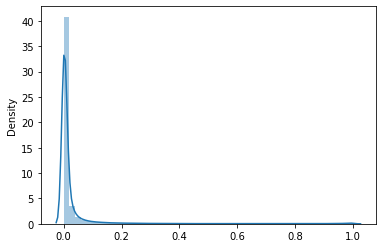

In [13]:
import seaborn as sns
sns.distplot(pre)